In [1]:
import os, sys
import importlib

from utils import load, vis, models, models_LSTM, process

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#importlib.reload(vis)
data_folder = "data/simplified/"
#access_file_generator = map(lambda x : data_folder + x + '.csv', load.classes)
afg2 = map(lambda x : data_folder + x + '.csv', load.classes)

In [3]:
batch_size = 8
steps = int(10 * 16/batch_size)
test_size = int(1000*16/batch_size)

In [4]:
data = process.SeqGenerator(afg2,100,batch_size)
gen2 = data.generateSeq()

In [6]:
importlib.reload(models_LSTM)

model2 = models_LSTM.DoodleLSTM((None,3), data.n_classes)
model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, None, 3)           12        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 48)          768       
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 48)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          15424     
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 96)          18528     
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 96)          0         
__________

In [7]:
history = model2.fit_generator(generator=gen2, epochs=640, steps_per_epoch=steps)

Epoch 1/640
20/20 [==============================] - 4s 214ms/step - loss: 1.9513 - acc: 0.1742
Epoch 2/640
20/20 [==============================] - 1s 65ms/step - loss: 1.7917 - acc: 0.2656
Epoch 3/640
20/20 [==============================] - 1s 62ms/step - loss: 1.8074 - acc: 0.2805
Epoch 4/640
20/20 [==============================] - 1s 68ms/step - loss: 1.7488 - acc: 0.3063
Epoch 5/640
20/20 [==============================] - 1s 68ms/step - loss: 1.6685 - acc: 0.3422
Epoch 6/640
20/20 [==============================] - 2s 77ms/step - loss: 1.6271 - acc: 0.3445
Epoch 7/640
20/20 [==============================] - 1s 63ms/step - loss: 1.6389 - acc: 0.3344
Epoch 8/640
20/20 [==============================] - 1s 71ms/step - loss: 1.6544 - acc: 0.3484
Epoch 9/640
20/20 [==============================] - 1s 71ms/step - loss: 1.7508 - acc: 0.3023
Epoch 10/640
20/20 [==============================] - 1s 69ms/step - loss: 1.9884 - acc: 0.2094
Epoch 11/640
20/20 [============================

20/20 [==============================] - 1s 68ms/step - loss: 0.6949 - acc: 0.7641
Epoch 86/640
20/20 [==============================] - 1s 66ms/step - loss: 0.7964 - acc: 0.7289
Epoch 87/640
20/20 [==============================] - 1s 65ms/step - loss: 0.7672 - acc: 0.7508
Epoch 88/640
20/20 [==============================] - 1s 63ms/step - loss: 0.7822 - acc: 0.7398
Epoch 89/640
20/20 [==============================] - 1s 64ms/step - loss: 0.7523 - acc: 0.7492
Epoch 90/640
20/20 [==============================] - 1s 65ms/step - loss: 0.7823 - acc: 0.7320
Epoch 91/640
20/20 [==============================] - 1s 67ms/step - loss: 0.6861 - acc: 0.7789
Epoch 92/640
20/20 [==============================] - 2s 79ms/step - loss: 0.6913 - acc: 0.7734
Epoch 93/640
20/20 [==============================] - 1s 69ms/step - loss: 0.6639 - acc: 0.7805
Epoch 94/640
20/20 [==============================] - 1s 68ms/step - loss: 0.7342 - acc: 0.7562
Epoch 95/640
20/20 [==============================] -

20/20 [==============================] - 1s 63ms/step - loss: 0.3408 - acc: 0.8938
Epoch 170/640
20/20 [==============================] - 1s 65ms/step - loss: 0.3613 - acc: 0.8820
Epoch 171/640
20/20 [==============================] - 1s 65ms/step - loss: 0.4049 - acc: 0.8719
Epoch 172/640
20/20 [==============================] - 1s 63ms/step - loss: 0.3353 - acc: 0.8836
Epoch 173/640
20/20 [==============================] - 1s 64ms/step - loss: 0.3587 - acc: 0.8797
Epoch 174/640
20/20 [==============================] - 1s 72ms/step - loss: 0.3775 - acc: 0.8813
Epoch 175/640
20/20 [==============================] - 1s 69ms/step - loss: 0.3341 - acc: 0.8930
Epoch 176/640
20/20 [==============================] - 1s 63ms/step - loss: 0.4063 - acc: 0.8703
Epoch 177/640
20/20 [==============================] - 1s 67ms/step - loss: 0.3357 - acc: 0.8922
Epoch 178/640
20/20 [==============================] - 1s 64ms/step - loss: 0.4174 - acc: 0.8633
Epoch 179/640
20/20 [=======================

20/20 [==============================] - 1s 72ms/step - loss: 0.2954 - acc: 0.9047
Epoch 254/640
20/20 [==============================] - 1s 72ms/step - loss: 0.3923 - acc: 0.8875
Epoch 255/640
20/20 [==============================] - 1s 73ms/step - loss: 0.2924 - acc: 0.9086
Epoch 256/640
20/20 [==============================] - 2s 76ms/step - loss: 0.3078 - acc: 0.9062
Epoch 257/640
20/20 [==============================] - 1s 63ms/step - loss: 0.2986 - acc: 0.9016: 0s - loss: 0.2952 - acc:
Epoch 258/640
20/20 [==============================] - 1s 73ms/step - loss: 0.3191 - acc: 0.8914
Epoch 259/640
20/20 [==============================] - 1s 65ms/step - loss: 0.2876 - acc: 0.9117
Epoch 260/640
20/20 [==============================] - 1s 67ms/step - loss: 0.3077 - acc: 0.9109
Epoch 261/640
20/20 [==============================] - 1s 68ms/step - loss: 0.3261 - acc: 0.8992
Epoch 262/640
20/20 [==============================] - 1s 64ms/step - loss: 0.3159 - acc: 0.9125
Epoch 263/640
20/2

20/20 [==============================] - 1s 67ms/step - loss: 0.2995 - acc: 0.9047: 0s - loss: 0.3086 - acc: 0.90
Epoch 337/640
20/20 [==============================] - 1s 62ms/step - loss: 0.2497 - acc: 0.9148
Epoch 338/640
20/20 [==============================] - 1s 73ms/step - loss: 0.3058 - acc: 0.9125
Epoch 339/640
20/20 [==============================] - 1s 67ms/step - loss: 0.2924 - acc: 0.9062
Epoch 340/640
20/20 [==============================] - 1s 70ms/step - loss: 0.3322 - acc: 0.9023: 0s - loss: 0.3286 - ac
Epoch 341/640
20/20 [==============================] - 1s 69ms/step - loss: 0.2916 - acc: 0.9133
Epoch 342/640
20/20 [==============================] - 1s 61ms/step - loss: 0.2922 - acc: 0.9078
Epoch 343/640
20/20 [==============================] - 1s 66ms/step - loss: 0.2780 - acc: 0.9187
Epoch 344/640
20/20 [==============================] - 1s 62ms/step - loss: 0.2130 - acc: 0.9312
Epoch 345/640
20/20 [==============================] - 1s 65ms/step - loss: 0.2856 - a

20/20 [==============================] - 1s 72ms/step - loss: 0.2669 - acc: 0.9164
Epoch 420/640
20/20 [==============================] - 1s 69ms/step - loss: 0.2659 - acc: 0.9242
Epoch 421/640
20/20 [==============================] - 1s 69ms/step - loss: 0.2465 - acc: 0.9219
Epoch 422/640
20/20 [==============================] - 1s 72ms/step - loss: 0.2828 - acc: 0.9141
Epoch 423/640
20/20 [==============================] - 1s 68ms/step - loss: 0.2849 - acc: 0.9211
Epoch 424/640
20/20 [==============================] - 1s 64ms/step - loss: 0.2724 - acc: 0.9180
Epoch 425/640
20/20 [==============================] - 1s 62ms/step - loss: 0.2621 - acc: 0.9234
Epoch 426/640
20/20 [==============================] - 1s 63ms/step - loss: 0.2456 - acc: 0.9250
Epoch 427/640
20/20 [==============================] - 1s 60ms/step - loss: 0.2250 - acc: 0.9219
Epoch 428/640
20/20 [==============================] - 1s 60ms/step - loss: 0.2425 - acc: 0.9219
Epoch 429/640
20/20 [=======================

20/20 [==============================] - 1s 74ms/step - loss: 0.2855 - acc: 0.9141
Epoch 504/640
20/20 [==============================] - 1s 66ms/step - loss: 0.2325 - acc: 0.9305
Epoch 505/640
20/20 [==============================] - 1s 63ms/step - loss: 0.2195 - acc: 0.9328
Epoch 506/640
20/20 [==============================] - 1s 63ms/step - loss: 0.2334 - acc: 0.9266
Epoch 507/640
20/20 [==============================] - 1s 70ms/step - loss: 0.2115 - acc: 0.9383
Epoch 508/640
20/20 [==============================] - 1s 64ms/step - loss: 0.2407 - acc: 0.9305
Epoch 509/640
20/20 [==============================] - 1s 68ms/step - loss: 0.2527 - acc: 0.9203
Epoch 510/640
20/20 [==============================] - 1s 70ms/step - loss: 0.2058 - acc: 0.9367
Epoch 511/640
20/20 [==============================] - 1s 74ms/step - loss: 0.2878 - acc: 0.9117
Epoch 512/640
20/20 [==============================] - 1s 68ms/step - loss: 0.2127 - acc: 0.9352
Epoch 513/640
20/20 [=======================

20/20 [==============================] - 1s 68ms/step - loss: 0.2146 - acc: 0.9336
Epoch 588/640
20/20 [==============================] - 1s 64ms/step - loss: 0.2530 - acc: 0.9133
Epoch 589/640
20/20 [==============================] - 1s 65ms/step - loss: 0.2287 - acc: 0.9250
Epoch 590/640
20/20 [==============================] - 1s 74ms/step - loss: 0.2766 - acc: 0.9148
Epoch 591/640
20/20 [==============================] - 1s 65ms/step - loss: 0.1980 - acc: 0.9367
Epoch 592/640
20/20 [==============================] - 1s 69ms/step - loss: 0.2466 - acc: 0.9250
Epoch 593/640
20/20 [==============================] - 1s 74ms/step - loss: 0.2356 - acc: 0.9273
Epoch 594/640
20/20 [==============================] - 1s 70ms/step - loss: 0.2210 - acc: 0.9305
Epoch 595/640
20/20 [==============================] - 1s 67ms/step - loss: 0.2483 - acc: 0.9172
Epoch 596/640
20/20 [==============================] - 1s 63ms/step - loss: 0.1997 - acc: 0.9414
Epoch 597/640
20/20 [=======================

In [8]:
model2.evaluate_generator(generator = gen2, steps = test_size)

[0.20494517828943207, 0.9358671875]

In [9]:
# serialize model to JSON
model_json = model2.to_json()
with open("modelLSTM_8deep.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model2.save_weights("modelLSTM_8deep.h5")
print("Saved model to disk")

Saved model to disk


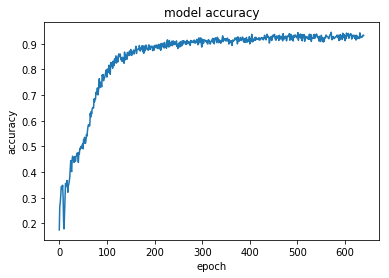

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig('8deep_class_acc')
plt.show()


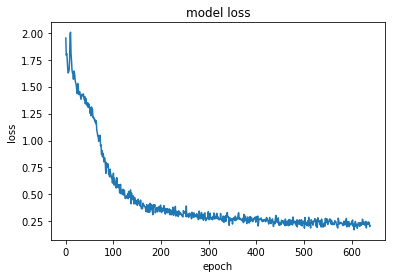

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('8deep_class_loss')
plt.show()

In [12]:
import json
with open('8deep_class_history.json', 'w') as f:
    json.dump(history.history, f)

In [ ]:
for layer in loaded_model.layers[:10]:
    layer.trainable = False

In [ ]:
from keras.models import model_from_json
# load json and create model
json_file = open('modelLSTM_32.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("modelLSTM_32.h5")
print("Loaded model from disk")

In [ ]:
loaded_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=['accuracy'])

In [ ]:
loaded_model.fit_generator(generator=gen2, epochs=200, steps_per_epoch=10)

In [ ]:
loaded_model.evaluate(x_test,y_test,verbose = 0)